In [2]:
% matplotlib inline
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from skimage.feature import hog

In [3]:
class neural_network():
    
    def __init__(self, layer_sizes=[784, 200, 26], step_size=0.1):
        self.layer_sizes = layer_sizes 
        self.step_size=step_size #??
        # support classical 3-layer network only
        self.V = np.random.normal(loc=0, scale=1/np.sqrt(layer_sizes[0]+1), size=(layer_sizes[1], layer_sizes[0]+1))
        self.W = np.random.normal(loc=0, scale=1/np.sqrt(layer_sizes[1]+1), size=(layer_sizes[2], layer_sizes[1]+1))
        
    # activation function: tanh
    def tanh(self, x):
        x = np.minimum(500, x)
        x = np.maximum(-500, x)
        a = np.exp(x)
        b = np.exp(-x)
        return (a-b)/(a+b)
    
    # derivative of tanh function
    def tanh_d(self, x):
        t = self.tanh(x)
        return 1 - np.multiply(t, t)
    
    # activation function: sigmoid
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    # derivative of sigmoid function
    def sigmoid_d(self, x):
        s = self.sigmoid(x)
        return np.multiply(s, 1-s)
    
    # activation function: ReLU
    def relu(self, x):
        return np.maximum(0, x)
    
    # derivative of ReLU function
    def relu_d(self, x):
        return (x>0).astype(float)
    
    # activation function: softmax
    def softmax(self, x):
        e = np.exp(x)
        return e / np.sum(e)
    
    # loss function: cross-entropy
    def cross_entropy(self, z, y):
        return -np.sum(np.multiply(y, np.log(z+1e-20)) + np.multiply((1-y), np.log(1-z+1e-20)))
    
    # derivative of cross-entropy loss function
    def cross_entropy_d(self, z, y):
        return -np.divide(y, z+1e-20) + np.divide((1-y), (1-z+1e-20))
    
    # calcluate h = s(Vx) and z = s(Wh), aka forward propagation
    def forward_prop(self, x):
        x1 = np.append(x, 1) # 1 at the end
        h = self.sigmoid(self.V.dot(x1)) # tanh for hidden layer
        h1 = np.append(h, 1) # 1 at the end
        z = self.sigmoid(self.W.dot(h1)) # sigmoid for output layer
        return x1, h1, z
        
    # calculate the gradient of weight matrices, aka backward propagation
    def backward_prop(self, x1, h1, z, y):
        dLdz = self.cross_entropy_d(z, y)
        s2d = self.sigmoid_d(self.W.dot(h1))
        # the gradient of W
        dW = np.outer(np.multiply(dLdz, s2d), h1)
        
        s1d = self.sigmoid_d(self.V.dot(x1))
        dLdh1 = np.sum(np.dot(np.diag(np.multiply(dLdz, s2d)), self.W), axis=0)
        dLdh = dLdh1[:-1] # don't include the 1
        # the gradient of V
        dV = np.outer(np.multiply(dLdh, s1d), x1)
        return dV, dW
    
    # vectorize data label
    def vectorize_y(self, y):
        M = np.max(y)
        N = len(y)
        yv = np.zeros([N, M])
        for i in range(N):
            yv[i, y[i]-1] = 1
        return yv
    
    # transform vectorized y back to labels
    def labelize_y(self, y):
        return np.argmax(y, axis=1) + 1
        
    # train NN using stochastic gradient descent
    # X: Nxd data matrix
    # y: Nx1 data label, range 1~26
    def train_sgd(self, X, y, N_epoch=10):
        all_loss = []
        yv = self.vectorize_y(y)
        for epoch in range(0, N_epoch):
            print('epoch #%d' % epoch)
            for i in range(X.shape[0]):
                xr = X[i, :]
                yr = yv[i, :]
                # FP
                x1, h1, z = self.forward_prop(xr)
                # BP
                dV, dW = self.backward_prop(x1, h1, z, yr)
                # GD
                self.V -= self.step_size * dV
                self.W -= self.step_size * dW
            print('  Training Accuracy: %f' % self.accuracy(X, y))
            all_loss.append(self.loss(X, yv))
        return all_loss
    
    def predict(self, X):
        z = np.zeros([len(X), len(self.W)])
        for i, x in enumerate(X):
            _, _, z[i, :] = self.forward_prop(x)
        z = np.argmax(z, axis=1) + 1
        return z
        
    def accuracy(self, X, y):
        z = self.predict(X)
        N = len(y)
        return np.sum(z == y) / float(N)
    
    def loss(self, X, y):
        loss = 0
        z = np.zeros([len(X), len(self.W)])
        for i, x in enumerate(X):
            _, _, z[i, :] = self.forward_prop(x)
        for i in range(len(z)):
            yi = y[i, :]
            zi = z[i, :]
            loss += self.cross_entropy(zi, yi)
        return loss / len(z)

## letters data

In [4]:
def center_data(X, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0) + 1e-10
    X = (X - mean) / std.T
    return X, mean, std

In [5]:
def view_image(data_row):
    plt.imshow(data_row.reshape([28,28]))
    plt.show()

In [6]:
# function that calculates the HOG feature
def hog_feature(data):
    data_hog = np.zeros(data.shape)
    for i in range(0, len(data)):
        if i % 1000 == 0:
            print(i)
        feature = data[i, :]
        image = feature.reshape(28, 28)
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualise=True)
        data_hog[i, :] = hog_image.ravel()
    return data_hog

In [7]:
data_name = './data/letters_data.mat'
data = scipy.io.loadmat(data_name)

In [8]:
train_X = data['train_x']
train_y = data['train_y'].ravel()
test_X = data['test_x']

In [9]:
idx = np.arange(len(train_y))
np.random.shuffle(idx)
train_X = train_X[idx, :]
train_y = train_y[idx]

In [10]:
# original feature
train_Xn, mean, std = center_data(train_X)
test_Xn, _, _ = center_data(test_X, mean, std)

In [295]:
# HOG feature
train_Xhn, mean, std = center_data(hog_feature(train_X))
test_Xhn, _, _ = center_data(hog_feature(test_X), mean, std)

0


C:\Users\Eason\AppData\Local\conda\conda\envs\py35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [11]:
nn = neural_network(layer_sizes=[784, 200, 26], step_size=1e-2)

epoch #0
  Training Accuracy: 0.708800
epoch #1
  Training Accuracy: 0.773600
epoch #2
  Training Accuracy: 0.816500
epoch #3
  Training Accuracy: 0.849600
epoch #4
  Training Accuracy: 0.878500
epoch #5
  Training Accuracy: 0.899800
epoch #6
  Training Accuracy: 0.915500
epoch #7
  Training Accuracy: 0.929500
epoch #8
  Training Accuracy: 0.941700
epoch #9
  Training Accuracy: 0.952600
epoch #10
  Training Accuracy: 0.958800
epoch #11
  Training Accuracy: 0.963800
epoch #12
  Training Accuracy: 0.968100
epoch #13
  Training Accuracy: 0.972300
epoch #14
  Training Accuracy: 0.976500
epoch #15
  Training Accuracy: 0.979600
epoch #16
  Training Accuracy: 0.981200
epoch #17
  Training Accuracy: 0.983500
epoch #18
  Training Accuracy: 0.984800
epoch #19
  Training Accuracy: 0.985900


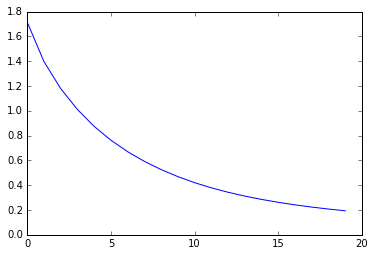

Wall time: 5min 24s


In [12]:
%%time
all_loss = nn.train_sgd(train_Xn[:10000, :], train_y[:10000], N_epoch=20)
plt.plot(all_loss)
plt.show()

In [21]:
nn.accuracy(train_Xn[100000:, :], train_y[100000:])

0.79334677419354838

Correct:
24 24


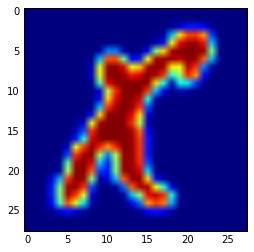

20 20


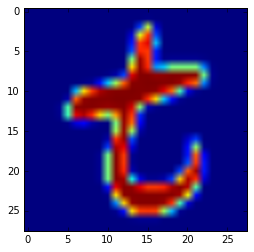

18 18


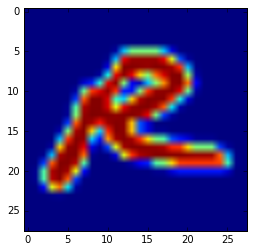

23 23


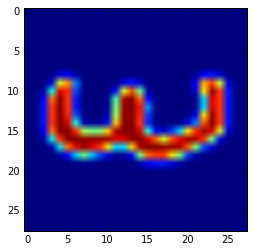

15 15


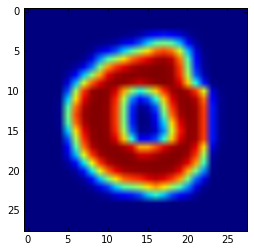

Wrong:
2 12


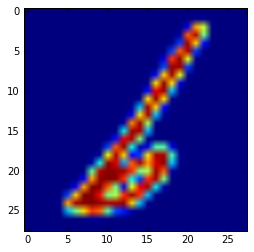

14 8


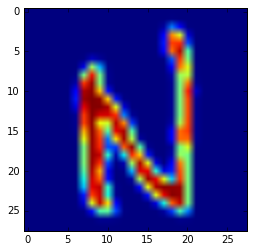

8 24


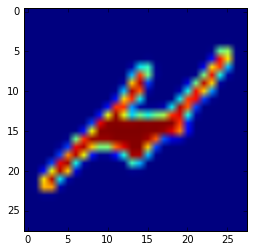

14 8


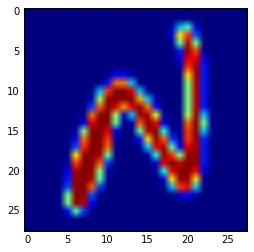

15 17


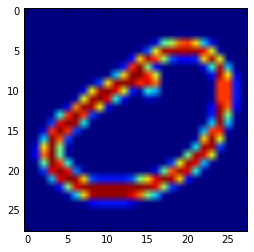

In [33]:
# visualization
validation_y = train_y[100000:]
validation_yp = nn.predict(train_Xn[100000:])
idx_right, = np.where(validation_y == validation_yp)
idx_wrong, = np.where(validation_y != validation_yp)
print('Correct:')
for i in idx_right[:5]:
    print(validation_y[i], validation_yp[i])
    view_image(train_X[100000+i, :])
print('Wrong:')
for i in idx_wrong[:5]:
    print(validation_y[i], validation_yp[i])
    view_image(train_X[100000+i, :])

(124800,)

16


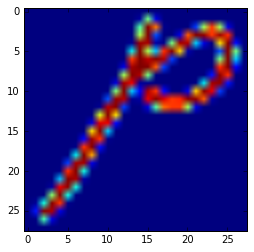

In [31]:
i = 21
print(train_y[i])
view_image(train_X[i, :])

In [328]:
test_y = nn.predict(test_Xhn)
df = pd.DataFrame({'Category': test_y})
df.index += 1
df.index.rename('Id', inplace=True)
df.to_csv('data/letters_hog_v1.csv')
print('Written to csv.')

Written to csv.


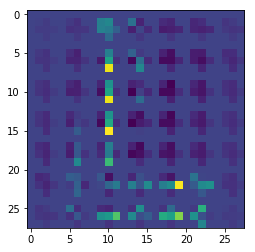

12


In [296]:
i = 10
view_image(test_Xhn[i, :])
print(test_y[i])

In [218]:
%%time
nn1 = neural_network()
dV = nn1.V
dW = nn1.W

yv = nn1.vectorize_y(train_y)
for epoch in range(5):
    print(epoch)
    for i in range(10000):
        xr = train_Xn[i, :]
        yr = yv[i, :]
        nn1.V -= 2*dV
        nn1.W -= 2*dW

0
1
2
3
4
Wall time: 23.7 s


In [182]:
train_Xn.shape

(124800, 784)

In [174]:
def test_exp(x):
    return np.exp(x)